In [55]:
# -*- coding: <encoding name> -*-
"""Create parameters.py and load it"""
# Directory for .inp file:
#path = 'INP file examples//chemkin_AR_HE_1_reac.inp'
#path = 'INP fil examples//notused_reactions_commented_chemkin_AR_HE.inp'
#path = 'INP file examples//chem_Otomo2018.inp'
#path = 'INP file examples//chemkin_AR_HE.inp'
#path = 'INP file examples//chem_Otomo2018_1reak.inp'
path = 'INP file examples//chem_Otomo2018_without_O_reactions.inp'

# import libraries:
import importlib   # For reloading your own files
import numpy as np
# my own files:
import inp_data_extractor as inp   # numeric constants and coefficents
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

Note, lambda value for specie 'NO' is not in data.py: 0.0 is used
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'O' is not in data.py: 0.0 is used
Note, lambda value for specie 'OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HO2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NO' is not in data.py: 0.0 is used
Note, lambda value for specie 'HNOH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HNO' is not in data.py: 0.0 is used
Note, lambda value for specie 'HON' is not in data.py: 0.0 is used
Note, lambda value for specie 'HONO' is not in data.py: 0.0 is used

In [56]:
"""Import simulation"""
import numpy as np
import importlib
import full_bubble_model as de
importlib.reload(de)

model: INP file examples//chem_Otomo2018_without_O_reactions
Enable heat transfer: True, enable evaporation: False, enable reactions: True


<module 'full_bubble_model' from 'C:\\Users\\mrkf9\\Documents\\KozakAron\\python\\ammonia_TDK_simulation\\Bubble_dynamics_simulation\\full_bubble_model.py'>

In [57]:
"""Control parameters"""
cpar = de.dotdict(dict(
    ID=0,
    R_E=10.0e-6, # [m]
    ratio=5.5, # [-]
    P_amb=-20000,#1.01325e5, # [Pa]
    alfa_M=0.35, # [-]
    T_inf= 293.15, # [K]  #5000.0,
    surfactant=1.0, # [-]
    gases=[par.index['H2'], par.index['N2']], # indexes of species in initial bubble
    fractions=[0.75, 0.25], # molar fractions of species in initial bubble
    P_v = 2338.1, # [Pa]
    mu_L = 0.001, # [Pa*s]
    freq1=2.0e4,                          # [Hz]
    freq2=1.0e5,                          # [Hz]
    pA1=0.0e5,                            # [Pa]
    pA2=0.0e5,                            # [Pa]
    theta_phase=0.1,                      # [rad]
    c_L=1483.0,                            # [m/s]
))

In [29]:
    #Checking first derivative (f(t_start,x(t_start))):
    T_inf= 1000.0 # [K]
    P_amb=1.01325e5 # [Pa]
    alfa_M = 0.35  # [-]
    surfactant=1.0 # [-]
    mu_L = 0.001 # [Pa*s]
    P_v = 2338.1 # [Pa]
    freq1=2.0e4                          # [Hz]
    freq2=1.0e5                          # [Hz]
    pA1=0.0e5                            # [Pa]
    pA2=0.0e5                            # [Pa]
    theta_phase=0.1                      # [rad]
    t=0.0 # [s]
    enable_evaporation = True
    enable_heat_transfer = True
    enable_reactions = True
    
    import numpy as np
    importlib.reload(de)
    IC = de.InitialCondition(cpar)
    import matplotlib.pyplot as plt   # for plotting
    import numpy as np   # matrices, math
    from scipy.integrate import solve_ivp   # differential equation solver
    from scipy.signal import argrelmin   # loc min finding
    import time   # runtime measurement
    from numba import njit   # Just In Time compiler
    from numba.types import unicode_type, float64, float32, int64, int32   # JIT types
    from func_timeout import func_timeout, FunctionTimedOut   # for timeout
    import os    # file management
    import importlib   # for reloading your own files

    # dot.notation access to dictionary attributes
    # instead of dictionary['key'] you can use dictionary.key
    class dotdict(dict):
        __getattr__ = dict.get
        __setattr__ = dict.__setitem__
        __delattr__ = dict.__delitem__
    
    x=IC
    R = x[0]      # bubble radius [m]
    R_dot = x[1]  # [m/s]
    T = x[2]      # temperature [K]
    c = x[3:-1]     # molar concentration [mol/cm^3]
    #print('c:')
    #print(c)
    M = np.sum(c) # sum of concentration
    X = c / M     # mole fraction [-]
    dxdt = np.zeros(x.shape, dtype = np.float64)
    
# d/dt R
    dxdt[0] = R_dot
# Evaporation
    n_net_dot = 0.0  
    evap_energy = 0.0
    if enable_evaporation:
        n_net_dot, evap_energy = de.Evaporation(M=M, T=T, X_H2O=X[par.indexOfWater], alfa_M=alfa_M, T_inf=T_inf, P_v=P_v)
# Thermodynamics
    [C_p, H, S, C_v] = de.Thermodynamic(c=c, T=T)
    W_avg = np.sum(X * par.W)
    rho_avg = W_avg * M # or np.sum(c * par.W)
    C_p_avg = np.sum(X * C_p)
    C_v_avg = np.sum(X * C_v)

    lambda_avg = np.sum(X * par.lambdas)
    chi_avg = 10.0 * lambda_avg * W_avg / (C_p_avg * rho_avg)
    l_th = np.inf
    if R_dot != 0.0:
        l_th = np.sqrt(R * chi_avg / abs(R_dot))
    l_th = min(l_th, R / np.pi)
    Q_th_dot = 0.0
    if enable_heat_transfer:
        Q_th_dot = lambda_avg * (T_inf - T) / l_th
# d/dt c
    omega_dot = np.zeros((par.K), dtype = np.float64)
    if enable_reactions:
        omega_dot = de.ProductionRate(T=T, H=H, S=S, c=c, P_amb=P_amb, M=M)
    c_dot = omega_dot - c * 3.0 * R_dot / R
    c_dot[par.indexOfWater] += 1.0e-6 * n_net_dot * 3.0 / R    # water evaporation
    dxdt[3:-1] = c_dot
# d/dt T
    Q_r_dot = -np.sum(H * omega_dot) + np.sum(omega_dot) * par.R_erg * T
    p = 0.1 * M * par.R_erg * T
    T_dot = (Q_r_dot + 30.0 / R * (-p * R_dot + Q_th_dot + evap_energy)) / (M * C_v_avg)
    dxdt[2] = T_dot
# d/dt R_dot
    [delta, delta_dot, p_dot] = de.Pressure(t=t,
        R=R, R_dot=R_dot, T=T, T_dot=T_dot,
        M=M, sum_omega_dot=np.sum(omega_dot),
        P_amb=P_amb, mu_L=mu_L, surfactant=surfactant,
        freq1=freq1, freq2=freq2, pA1=pA1, pA2=pA2, theta_phase=theta_phase
    )   # delta = (p_L-p_inf) / rho_L
    Nom = (1.0 + R_dot / par.c_L) * delta + R / par.c_L * delta_dot - (1.5 - 0.5 * R_dot / par.c_L) * R_dot ** 2
    Den = (1.0 - R_dot / par.c_L) * R + 4.0 * mu_L / (par.c_L * par.rho_L)
    
    dxdt[1] = Nom / Den
    
    M_eff = np.sum(c) * np.ones((par.I), dtype = np.float64)    # effective total concentration of the third-body 
    #print(par.ThirdBodyIndexes)
    for j, i in enumerate(par.ThirdBodyIndexes):
        M_eff[i] = np.sum(par.alfa[j] * c)
    
    k_forward = par.A * T ** par.b * np.exp(-par.E / (par.R_cal * T))
    #print('k_forward[12]: '+str(k_forward[12]))


    LindemannIndex=0
    TroeIndex=0
    SRIIndex=0
    
    for j, i in enumerate(par.PressureDependentIndexes):    # i is the number of reaction, j is the index of i's place in par.PressureDependentIndexes
        k_inf = k_forward[i]    # par.A[i] * T ** par.b[i] * np.exp(-par.E[i] / (par.R_cal * T))
        k_0 = par.ReacConst[j][0] * T ** par.ReacConst[j][1] * np.exp(-par.ReacConst[j][2] / (par.R_cal * T))
        P_r = k_0 / k_inf * M_eff[i]
        #print('P_r: '+str(P_r))
        logP_r = np.log10(P_r)
        
         # Lindemann formalism
        if i in par.LindemannIndexes:
            F = 1.0
            #print('F: '+str(F))
            LindemannIndex += 1

    # Troe formalism
        elif i in par.TroeIndexes:
            F_cent = (1.0 - par.Troe[TroeIndex][0]) * np.exp(-T / par.Troe[TroeIndex][1]) + par.Troe[TroeIndex][0] * np.exp(-T / par.Troe[TroeIndex][2]) + np.exp(-par.Troe[TroeIndex][3] / T)
            logF_cent = np.log10(F_cent)
            c2 = -0.4 - 0.67 * logF_cent
            n = 0.75 - 1.27 * logF_cent
            d = 0.14
            logP_r = np.log10(P_r)
            logF = 1.0 / (1.0 + ((logP_r + c2) / (n - d * (logP_r + c2))) ** 2) * logF_cent
            F = 10.0 ** logF
            #print('F: '+str(F)+', number of par.TroeIndexes: '+str(TroeIndex))
            TroeIndex += 1
        
        # SRI formalism
        elif i in par.SRIIndexes: 
            X = 1.0 / (1.0 + np.log10(P_r)**2)
            F = par.SRI[SRIIndex][3] * (par.SRI[SRIIndex][0] * np.exp(-par.SRI[SRIIndex][1] / T) + np.exp(-T / par.SRI[SRIIndex][2]))**X * T ** par.SRI[SRIIndex][4]
            SRIIndex += 1
        else:
            print('Error, the pressure-dependent reaction cannot be groupped in any type of pressure-dependent reactions!')      
      # Pressure dependent reactions END

        k_forward[i] = k_inf * P_r / (1.0 + P_r) * F
        #print('k_inf: '+str(k_inf)+', P_r: '+str(P_r)+', F: '+str(F))

  # PLOG reactions
    if par.PlogCount > 0:
        p = 0.1 * M * par.R_erg * T
    for j, i in enumerate(par.PlogIndexes):
        if p < par.Plog[3*j][0]:
            k_forward[i] = par.Plog[3*j][1] * T ** par.Plog[3*j][2] * np.exp(-par.Plog[3*j][3] / (par.R_cal * T))
        elif p < par.Plog[3*j+1][0]:
            k_1 = par.Plog[3*j][1] * T ** par.Plog[3*j][2] * np.exp(-par.Plog[3*j][3] / (par.R_cal * T))
            k_2 = par.Plog[3*j+1][1] * T ** par.Plog[3*j+1][2] * np.exp(-par.Plog[3*j+1][3] / (par.R_cal * T))
            ln_k = np.log(k_1) + (np.log(p) - np.log(par.Plog[3*j][0])) / (np.log(par.Plog[3*j+1][0]) - np.log(par.Plog[3*j][0])) * (np.log(k_2) - np.log(k_1))
            k_forward[i] = np.exp(ln_k)
        elif p < par.Plog[3*j+2][0]:
            k_2 = par.Plog[3*j+1][1] * T ** par.Plog[3*j+1][2] * np.exp(-par.Plog[3*j+1][3] / (par.R_cal * T))
            k_3 = par.Plog[3*j+2][1] * T ** par.Plog[3*j+2][2] * np.exp(-par.Plog[3*j+2][3] / (par.R_cal * T))
            ln_k = np.log(k_2) + (np.log(p) - np.log(par.Plog[3*j+1][0])) / (np.log(par.Plog[3*j+2][0]) - np.log(par.Plog[3*j+1][0])) * (np.log(k_3) - np.log(k_2))
            k_forward[i] = np.exp(ln_k)
        else:
            k_forward[i] = par.Plog[3*j+2][1] * T ** par.Plog[3*j+2][2] * np.exp(-par.Plog[3*j+2][3] / (par.R_cal * T))
           
    #for i in range(len(k_forward)):
    #    print('k_forward['+str(i)+']:'+str(k_forward[i]))
    
    
    #for i in range(len(k_forward)):
    #    print(k_forward[i])->OK
    k_backward=de.BackwardRate(k_forward=k_forward, S=S, H=H, T=T, P_amb=P_amb)
    #for i in range(len(k_forward)):
    #    print(k_backward[i])->OK
    
    q = np.zeros((par.I), dtype = np.float64)
    for i in range(par.I):
        q[i] = k_forward[i] * np.prod(c ** par.nu_forward[i]) - k_backward[i] * np.prod(c ** par.nu_backward[i])
    # Third body reactions
    for j, i in enumerate(par.ThirdBodyIndexes):    # i is the number of reaction, j is the index of i in par.ThirdBodyIndexes
        if i not in par.PressureDependentIndexes:
            q[i] *= M_eff[i]
            
    
    
    omega_dot = np.zeros((par.K), dtype=np.float64)
    for k in range(par.K):
        omega_dot[k] = np.sum(par.nu[:, k] * q)
    #print('\n\n')
    #print(k_forward)
    #print('n_net_dot: '+str(n_net_dot)+', evap_energ: '+str(evap_energy))
    #print('Enable_evaporation: '+str(enable_evaporation))
    #print('p: '+str(p)+'Pa')
    #print('omega_dot: '+str(omega_dot)+' mol/cm^3')
    #print('dxdt: '+str(dxdt)+' SI')
    
    t=0.0
    dxdt=de.f(t, x, alfa_M, T_inf, P_v, P_amb, mu_L, surfactant, freq1, freq2, pA1, pA2, theta_phase, cpar.c_L)
    #print(dxdt)

model: INP file examples//chem_Otomo2018_without_O_reactions
Enable heat transfer: True, enable evaporation: False, enable reactions: True


IndexError: tuple index out of range

Error! The pressure of the gas is negative!
succecfully solved with LSODA solver


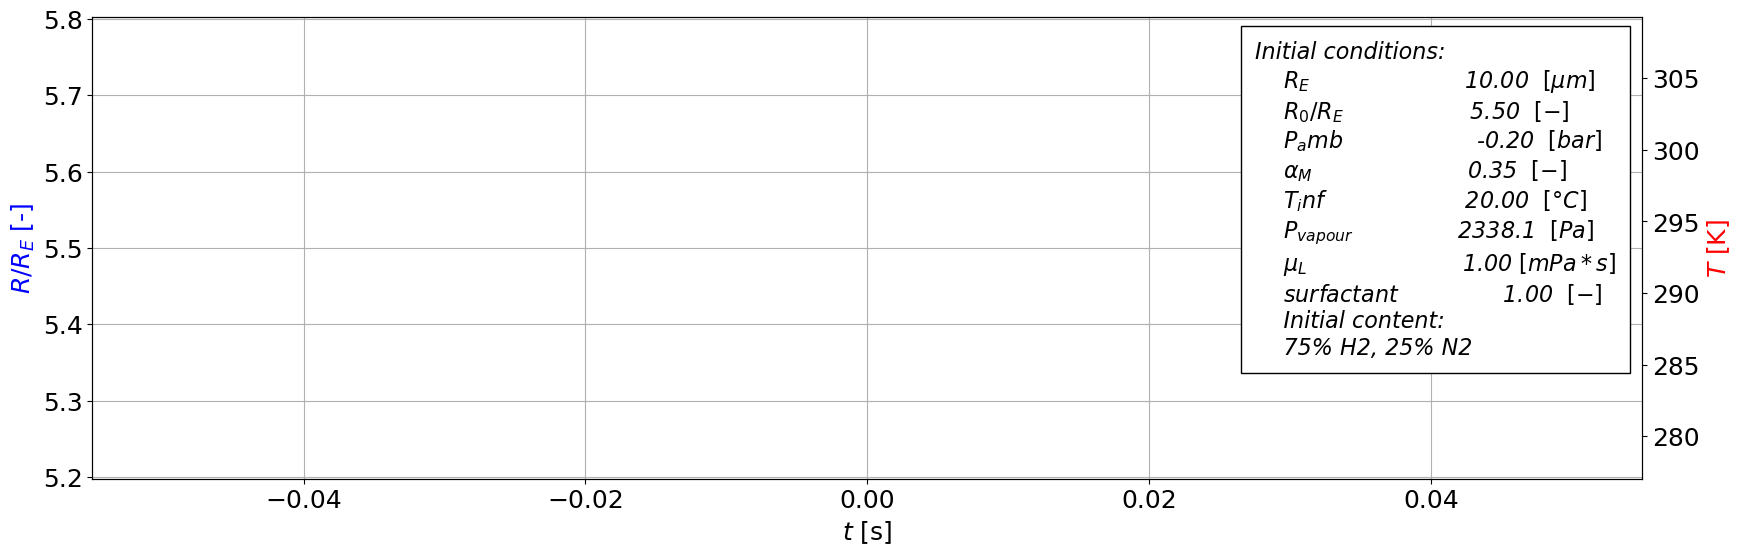

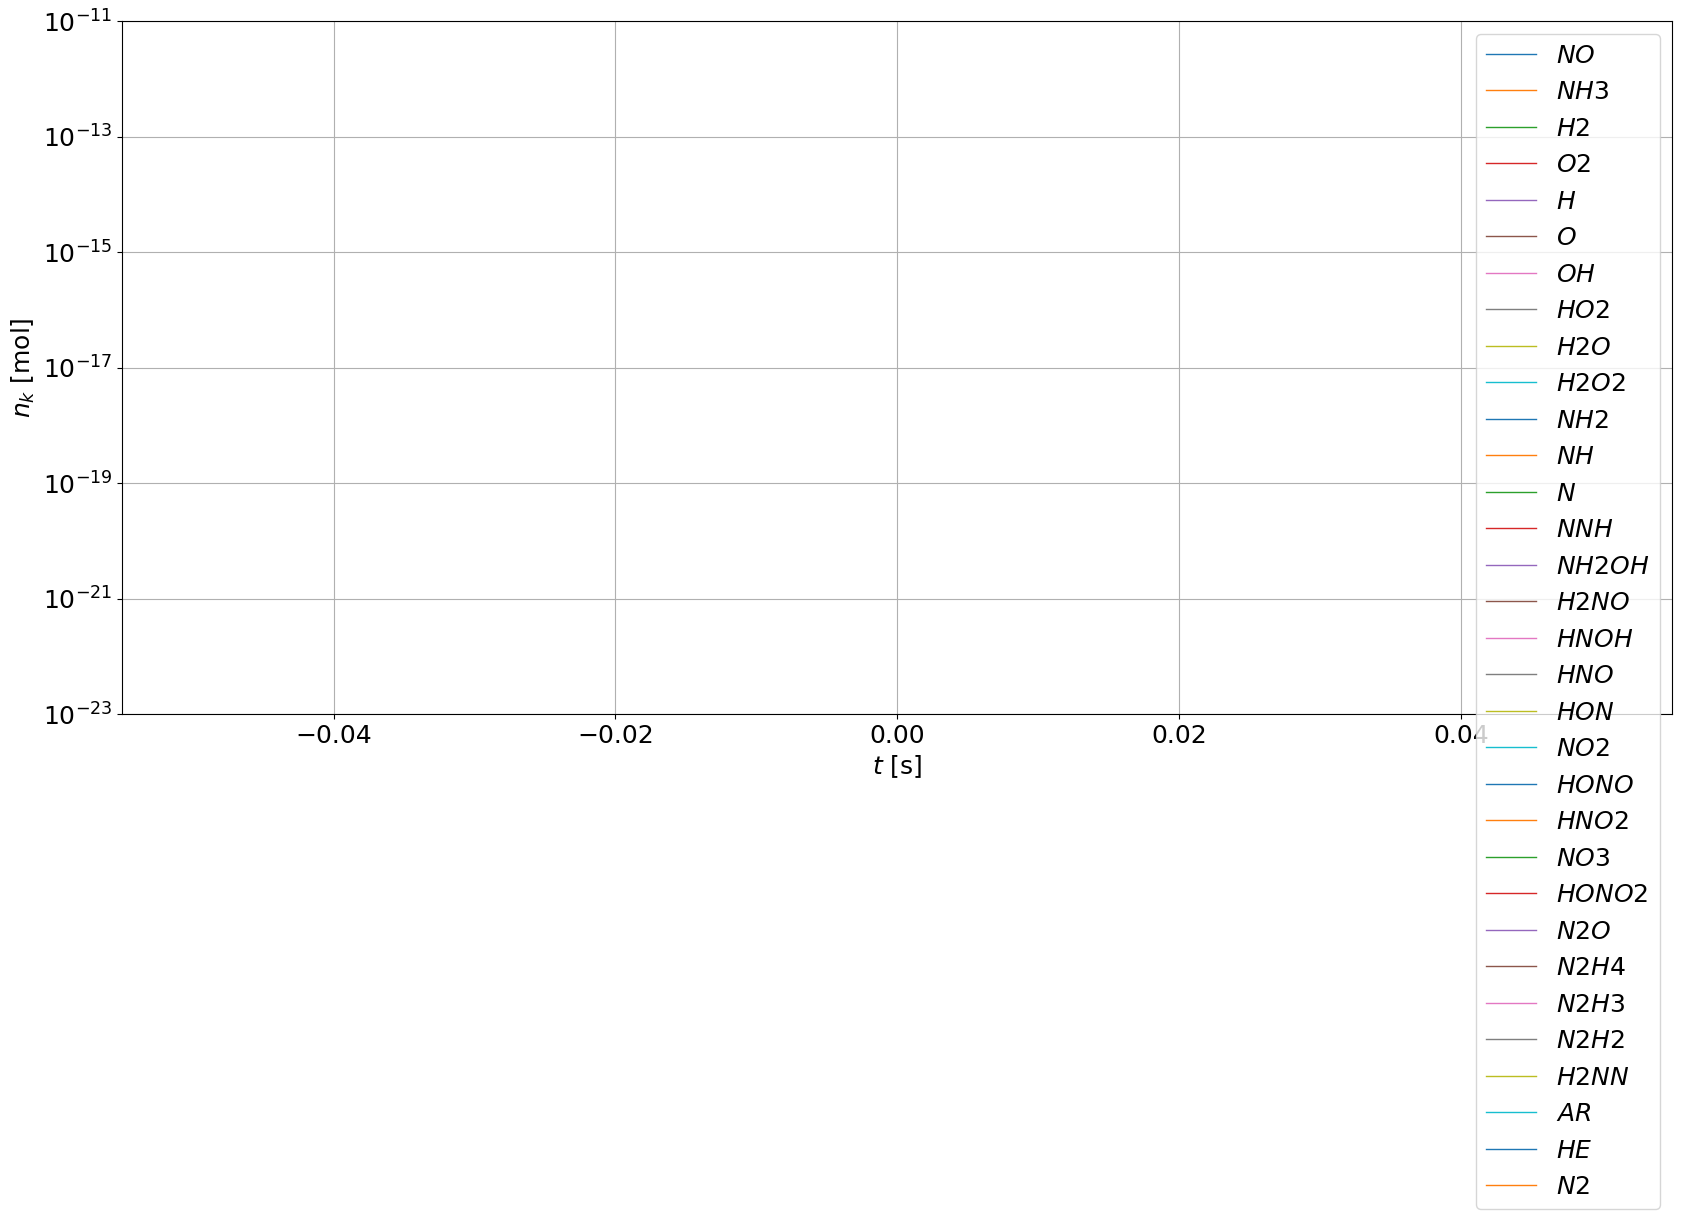

Control parameters:
    ID = 0
    R_E = 10.00 [um]
    ratio = 5.50 [-]
    P_amb =-0.20 [bar]
    alfa_M = 0.35 [-]
    T_inf = 20.00 [°C]
    P_v = 2338.10 [Pa]
    mu_L = 1.00 [mPa*s]
    surfactant = 1.00 [-]    
    freq1 = 20000 [Hz]
    freq2 = 100000 [Hz]
    pA1 = 0 [Pa]
    pA2 = 0 [Pa]
    theta_phase= 0.10 [rad]
75% H2, 25% N2
Simulation info:
    error_code = 0
    elapsed_time = 0.00 [s]
    steps = 0 [-]
Final state:
    R_final = 0.00 [um];   R_dot_final =0.0 [m/s];   T_final = 0.00 [K]
    n_H2 =0.0 [mol]; n_O2 =0.0 [mol]; n_NH3=0.0 [mol];
    Final molar concentrations: [mol/cm^3]
        NO: 0.0;  NH3: 0.0;  H2: 0.0;  O2: 0.0;  
        H: 0.0;  O: 0.0;  OH: 0.0;  HO2: 0.0;  
        H2O: 0.0;  H2O2: 0.0;  NH2: 0.0;  NH: 0.0;  
        N: 0.0;  NNH: 0.0;  NH2OH: 0.0;  H2NO: 0.0;  
        HNOH: 0.0;  HNO: 0.0;  HON: 0.0;  NO2: 0.0;  
        HONO: 0.0;  HNO2: 0.0;  NO3: 0.0;  HONO2: 0.0;  
        N2O: 0.0;  N2H4: 0.0;  N2H3: 0.0;  N2H2: 0.0;  
        H2NN: 0.0;  A

In [58]:
"""Plotting"""
import numpy as np
de.plot(cpar, t_int=np.array([0.0, 0.005]))

In [59]:
"""Saving"""
import numpy as np
file = de.Make_dir('test', separator=',')   # it makes a folder named 'test' in which it will save data
num_sol, error_code, elapsed_time, negativepressure_error = de.solve(cpar, t_int=np.array([0.0, 0.005]))   # simulation without plotting
data = de.get_data(cpar, num_sol, error_code, elapsed_time, negativepressure_error)   # post processing
file.write_solution(data, num_sol, 'testfile')   # saving (it overwrites data)

# If you would like to save data in an other format you should modify the list_to_string method in fubll_bubble_model.py, class Make_dir.
# If you would like to save data in other order you should modify the write_solution method. 

Folder already exists with 2 csv in it
Error! The pressure of the gas is negative!


C:\Users\mrkf9\Documents\KozakAron\python\ammonia_TDK_simulation\Bubble_dynamics_simulation\full_bubble_model.py:743: RuntimeWarning: invalid value encountered in double_scalars
  line = self.list_to_string([num_sol.t[i]] + list(num_sol.y[:-1, 0]) + list(num_sol.y[:-1, i]) + [data.expansion_work,num_sol.y[-1, i],1.0e-6 * (data.expansion_work+num_sol.y[-1,i]) / (1.0e-3 * num_sol.y[3+par.index['NH3'],i] * 4.0/3.0*np.pi*(100.0 *num_sol.y[0,i])**3 * par.W[par.index['NH3']])]) # [MJ/kg]
